### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass



### Activation Functions
- sigmoid
- tanh
- ReLu
- Leaky ReLu
- ELu


In [ ]:
class ActivationFunction:
  """
  This is a parent class for activation functions.
  Methods evaluate and evaluate_derivative need to be overridden by each activation function implementation
  """

  def __init__(self):
    self.vectorized_evaluate = np.vectorize(self.evaluate)
    self.vectorized_evaluate_derivative = np.vectorize(self.evaluate_derivative)

  def evaluate(self, x):
    raise NotImplementedError('This method should be overridden by a subclass implementation')

  def evaluate_derivative(self, x):
    """
    This is the derivative with respect to the already activated output of the network
    """
    raise NotImplementedError('This method should be overridden by a subclass implementation')

  def evaluate_vector(self, x):
    return self.vectorized_evaluate(x)

  def evaluate_derivative_vector(self, x):
    return self.vectorized_evaluate_derivative(x)

class Sigmoid(ActivationFunction):
  def evaluate(self, x):
    return 1 / (1 + np.exp(-x))

  def evaluate_derivative(self, x):
    return self.evaluate(x) * (1.0 - self.evaluate(x))

class Tanh(ActivationFunction):
  def evaluate(self, x):
    return np.tanh(x)

  def evaluate_derivative(self, x):
    return 1 - self.evaluate(x) ** 2

class Relu(ActivationFunction):
  def evaluate(self, x):
    return x if x > 0 else 0

  def evaluate_derivative(self, x):
    return 1 if x > 0 else 0

class LeakyRelu(ActivationFunction):
  """
  LeakyReLu function for alpha=0.3
  """
  def evaluate(self, x):
    return x if x > 0 else 0.3 * x

  def evaluate_derivative(self, x):
    return 1 if x > 0 else 0.3

class Elu(ActivationFunction):
  """
  ELu function for alpha=0.3
  """
  def evaluate(self, x):
    return x if x > 0 else 0.3 * (np.exp(x) - 1)

  def evaluate_derivative(self, x):
    return 1 if x > 0 else 0.3 * (np.exp(x))



### XOR net implementation


In [ ]:

class XorNet:
  """
  Given a learning_rate, a dictionary of initial weights and an activation function,
  XorNet simulates the corresponding neural network with one hidden layer.
  """

  # Below is the mapping between the keys of the dictionary of initial weights and
  # their interpretation in the XOR neural network
  BIAS_TO_HIDDEN_LAYER_1 = 0
  X1_TO_HIDDEN_LAYER_1 = 1
  X2_TO_HIDDEN_LAYER_1 = 2
  BIAS_TO_HIDDEN_LAYER_2 = 3
  X1_TO_HIDDEN_LAYER_2 = 4
  X2_TO_HIDDEN_LAYER_2 = 5
  BIAS_TO_OUTPUT_LAYER = 6
  HIDDEN_LAYER_1_TO_OUTPUT_LAYER = 7
  HIDDEN_LAYER_2_TO_OUTPUT_LAYER = 8

  # Below are the identifier strings that will be used to refer
  # to the outputs of the layers of the XOR network
  OUTPUT_BEFORE_ACTIVATION = 'output_before_activation'
  OUTPUT = 'output'
  HIDDEN_LAYER_OUTPUT_BEFORE_ACTIVATION = 'hidden_layer_output_before_activation'
  HIDDEN_LAYER_OUTPUT = 'hidden_layer_output'

  # Below are the idenitifier strings that will be used to refer to the gradients of the weights
  INPUT_TO_HIDDEN_WEIGHTS_GRADIENTS = 'input_to_hidden_weights_gradients'
  INPUT_TO_HIDDEN_BIAS_GRADIENTS = 'input_to_hidden_bias_gradients'
  HIDDEN_TO_OUTPUT_WEIGHT_GRADIENTS = 'hidden_to_output_weight_gradients'
  HIDDEN_TO_OUTPUT_BIAS_GRADIENT = 'hidden_to_output_bias_gradient'

  def __init__(self, activation_function: ActivationFunction, learning_rate, initial_weights):
    self.dataset = {
      (0, 0): 0,
      (1, 0): 1,
      (0, 1): 1,
      (1, 1): 0,
    }
    self.activation_function = activation_function
    self.learning_rate = learning_rate
    self.xor_net_vectorized = np.vectorize(self.xor_net)

    self.initial_weights = initial_weights
    self.input_to_hidden_weights = self.input_to_hidden_layer_weights_from(self.initial_weights)
    self.input_to_hidden_bias = self.input_to_hidden_layer_bias_from(self.initial_weights)
    self.hidden_to_output_weights = self.hidden_to_output_layer_weights_from(self.initial_weights)
    self.hidden_to_output_bias = self.hidden_to_output_layer_bias_from(self.initial_weights)

  def input_to_hidden_layer_weights_from(self, weights):
    """
    Creates matrix of input to hidden layer weights, out of the dictionary of initial weights.
    This will be useful to apply vectorization in forward and backward pass.
    """
    return np.array([
      [weights[self.X1_TO_HIDDEN_LAYER_1], weights[self.X2_TO_HIDDEN_LAYER_1]],
      [weights[self.X1_TO_HIDDEN_LAYER_2], weights[self.X2_TO_HIDDEN_LAYER_2]],
    ])

  def input_to_hidden_layer_bias_from(self, weights):
    """
    Creates matrix of input to hidden layer biases, out of the dictionary of initial weights.
    This will be useful to apply vectorization in forward and backward pass.
    """
    return np.array([
      [weights[self.BIAS_TO_HIDDEN_LAYER_1]],
      [weights[self.BIAS_TO_HIDDEN_LAYER_2]]
    ])

  def hidden_to_output_layer_weights_from(self, weights):
    """
    Creates matrix of hidden to output layer weights, out of the dictionary of initial weights.
    This will be useful to apply vectorization in forward and backward pass.
    """
    return np.array([
      [weights[self.HIDDEN_LAYER_1_TO_OUTPUT_LAYER],
       weights[self.HIDDEN_LAYER_2_TO_OUTPUT_LAYER], ]
    ])

  def hidden_to_output_layer_bias_from(self, weights):
    """
    Creates matrix of hidden to output layer bias, out of the dictionary of initial weights.
    This will be useful to apply vectorization in forward and backward pass.
    """
    return np.array([
      [weights[self.BIAS_TO_OUTPUT_LAYER]]
    ])

  def xor_net(self, x1, x2):
    """
    Performs the forward pass.
    Given x1 and x2 inputs, a dictionary of the outputs of all layers of the neural network are returned.
    The final output can be found at the key 'output' of the returned dictionary
    """

    hidden_layer_output_before_activation = self.hidden_layer_output_before_activation(x1, x2)
    hidden_layer_output = self.activation_function.evaluate_vector(hidden_layer_output_before_activation)
    output_before_activation = self.output_before_activation(hidden_layer_output)
    output = Sigmoid().evaluate_vector(output_before_activation)

    return {
      self.OUTPUT: output,
      self.OUTPUT_BEFORE_ACTIVATION: output_before_activation,
      self.HIDDEN_LAYER_OUTPUT: hidden_layer_output,
      self.HIDDEN_LAYER_OUTPUT_BEFORE_ACTIVATION: hidden_layer_output_before_activation,
    }

  def output_before_activation(self, hidden_layer_output):
    return np.dot(
      self.hidden_to_output_weights,
      hidden_layer_output
    ) + self.hidden_to_output_bias

  def hidden_layer_output_before_activation(self, x1, x2):
    return np.dot(self.input_to_hidden_weights, self.input_vector_from(x1, x2)) + self.input_to_hidden_bias

  def input_vector_from(self, x1, x2):
    return np.array([[x1], [x2]])

  def square_error_from(self, x1, x2, expected_output):
    """
    Returns the square error of one sample
    """
    return (expected_output - self.xor_net(x1, x2)[self.OUTPUT]) ** 2

  def mse(self):
    """
    Returns the mean square error out of the 4 samples of the dataset
    """
    return np.mean(
      [self.square_error_from(x1, x2, output) for ((x1, x2), output) in self.dataset.items()]
    )

  def grdmse(self):
    """
    Returns a dictionary with the gradients of each layer's weights and biases.
    Gradients for the 4 samples of the dataset are calculated and the mean is returned for each weight gradient.
    """
    x1_vector = np.array([input[0] for input in list(self.dataset.keys())])
    x2_vector = np.array([input[1] for input in list(self.dataset.keys())])
    expected_output_vector = np.array([[output] for _, output in self.dataset.items()])
    net_vector = self.xor_net_vectorized(x1_vector, x2_vector)

    output_vector = np.array([net[self.OUTPUT][0] for net in net_vector])
    output_before_activation_vector = np.array([net[self.OUTPUT_BEFORE_ACTIVATION][0] for net in net_vector])
    hidden_output_vector = np.array([net[self.HIDDEN_LAYER_OUTPUT] for net in net_vector])[:, :, 0]
    hidden_output_before_activation_vector = np.array(
      [net[self.HIDDEN_LAYER_OUTPUT_BEFORE_ACTIVATION] for net in net_vector])[:, :, 0]

    # The '2' in the below formula, was added because of the power of 2 that is present in the mean square formula
    delta_output = 2 * (output_vector - expected_output_vector) * Sigmoid().evaluate_derivative_vector(
      output_before_activation_vector)
    hidden_to_output_weights_gradients = delta_output * hidden_output_vector
    hidden_to_output_bias_gradients = delta_output

    delta_hidden_layer = delta_output * self.hidden_to_output_weights * self.activation_function.evaluate_derivative_vector(
      hidden_output_before_activation_vector)
    delta_hidden_layer = np.reshape(delta_hidden_layer,
                                    (np.shape(delta_hidden_layer)[0], np.shape(delta_hidden_layer)[1], 1))
    input_vectors = np.array([[x1_vector.transpose()], [x2_vector.transpose()]]).transpose()
    input_to_hidden_weights_gradients = delta_hidden_layer * input_vectors
    input_to_hidden_bias_gradients = delta_hidden_layer

    return {
      self.INPUT_TO_HIDDEN_BIAS_GRADIENTS: np.mean(input_to_hidden_bias_gradients, axis=0),
      self.INPUT_TO_HIDDEN_WEIGHTS_GRADIENTS: np.mean(input_to_hidden_weights_gradients, axis=0),
      self.HIDDEN_TO_OUTPUT_BIAS_GRADIENT: np.array([np.mean(hidden_to_output_bias_gradients, axis=0)]),
      self.HIDDEN_TO_OUTPUT_WEIGHT_GRADIENTS: np.array([np.mean(hidden_to_output_weights_gradients, axis=0)]),
    }

  def update_weights_using_grdmse(self):
    """
    Updates the weights of the XOR network by applying backpropagation based on the gradients of the weights
    """
    gradients = self.grdmse()

    self.input_to_hidden_weights -= self.learning_rate * gradients[self.INPUT_TO_HIDDEN_WEIGHTS_GRADIENTS]
    self.input_to_hidden_bias -= self.learning_rate * gradients[self.INPUT_TO_HIDDEN_BIAS_GRADIENTS]
    self.hidden_to_output_weights -= self.learning_rate * gradients[self.HIDDEN_TO_OUTPUT_WEIGHT_GRADIENTS]
    self.hidden_to_output_bias -= self.learning_rate * gradients[self.HIDDEN_TO_OUTPUT_BIAS_GRADIENT]

  def misclassified_samples(self):
    return np.sum(
      [self.is_misclassified(input, output) for (input, output) in self.dataset.items()]
    )

  def is_misclassified(self, input, output):
    return self.predicted_label_for(input[0], input[1]) != output

  def predicted_label_for(self, x1, x2):
    return 1 if self.xor_net(x1, x2)[self.OUTPUT] > 0.5 else 0


### Weights initialization functions
A dictionary of 9 weights is returned.
The keys are the indexes of the weights with respect to the XorNet class weight indexes
and the values are the values of the weights.
The following initialization methods were used:
- zeros
- ones
- normal distributed
- uniformly distributed
- xavier uniform and normal initialization
- he initialization


In [ ]:

NUMBER_OF_WEIGHTS_FOR_XOR_NETWORK = 9
INPUT_TO_HIDDEN_LAYER_WEIGHTS = 6
HIDDEN_TO_OUTPUT_LAYER_WEIGHTS = 3
INPUT_NODES_PLUS_BIAS = 3
HIDDEN_NODES_PLUS_BIAS = 3
OUTPUT_NODES = 1

def random_weights(low, high):
  return {
    index: value
    for index, value in enumerate(np.random.uniform(low, high) for _ in range(NUMBER_OF_WEIGHTS_FOR_XOR_NETWORK))
  }

def zero_weights():
  return {
    index: value
    for index, value in enumerate(np.zeros(NUMBER_OF_WEIGHTS_FOR_XOR_NETWORK))
  }

def one_weights():
  return {
    index: value
    for index, value in enumerate(np.ones(NUMBER_OF_WEIGHTS_FOR_XOR_NETWORK))
  }

def weights_from_normal_distribution(generator=np.random, mean=0, std=1):
  return {
    index: value
    for index, value in enumerate(generator.normal(mean, std, size=NUMBER_OF_WEIGHTS_FOR_XOR_NETWORK))
  }

def weights_from_uniform_distribution(generator=np.random, low=0, high=1):
  return {
    index: value
    for index, value in enumerate(generator.uniform(low, high, size=NUMBER_OF_WEIGHTS_FOR_XOR_NETWORK))
  }

"""
Xavier initialization method is based on the number of nodes of each layer.
It tries to create weights in such way so as for each passing layer, the 
variance  tends to remain the same for sigmoid and tanh activation functions
"""
def xavier_uniform_initialization(generator=np.random):
  weights = {}
  for i in range(INPUT_TO_HIDDEN_LAYER_WEIGHTS):
    weights[i] = generator.uniform(
      - math.sqrt(6) / math.sqrt(INPUT_NODES_PLUS_BIAS + HIDDEN_NODES_PLUS_BIAS),
      + math.sqrt(6) / math.sqrt(INPUT_NODES_PLUS_BIAS + HIDDEN_NODES_PLUS_BIAS)
    )

  for j in range(INPUT_TO_HIDDEN_LAYER_WEIGHTS, NUMBER_OF_WEIGHTS_FOR_XOR_NETWORK):
    weights[j] = generator.uniform(
      - math.sqrt(6) / math.sqrt(HIDDEN_NODES_PLUS_BIAS + OUTPUT_NODES),
      + math.sqrt(6) / math.sqrt(HIDDEN_NODES_PLUS_BIAS + OUTPUT_NODES)
    )
  return weights

def xavier_normal_initialization(generator=np.random):
  weights = {}
  for i in range(INPUT_TO_HIDDEN_LAYER_WEIGHTS):
    weights[i] = generator.normal(0, math.sqrt(2) / math.sqrt(INPUT_NODES_PLUS_BIAS + HIDDEN_NODES_PLUS_BIAS))
  
  for j in range(INPUT_TO_HIDDEN_LAYER_WEIGHTS, NUMBER_OF_WEIGHTS_FOR_XOR_NETWORK):
    weights[j] = generator.normal(0, math.sqrt(2) / math.sqrt(HIDDEN_NODES_PLUS_BIAS + OUTPUT_NODES))

  return weights

"""
He initialization method is based on the number of nodes of each layer.
It tries to create weights in such way so as for each passing layer, the 
variance  tends to remain the same for ReLu activation functions
"""
def he_initialization(generator=np.random):
  weights = {}
  for i in range(INPUT_TO_HIDDEN_LAYER_WEIGHTS):
    weights[i] = generator.uniform(
      - math.sqrt(2) / math.sqrt(INPUT_NODES_PLUS_BIAS),
      + math.sqrt(2) / math.sqrt(INPUT_NODES_PLUS_BIAS)
    )

  for j in range(INPUT_TO_HIDDEN_LAYER_WEIGHTS, NUMBER_OF_WEIGHTS_FOR_XOR_NETWORK):
    weights[j] = generator.uniform(
      - math.sqrt(2) / math.sqrt(HIDDEN_NODES_PLUS_BIAS),
      + math.sqrt(2) / math.sqrt(HIDDEN_NODES_PLUS_BIAS)
    )
  return weights



### Experiments infrastructure



#### Experiments configuration classes


In [ ]:

from dataclasses import dataclass

@dataclass
class Experiment:
  """
  This data class defines an experiment that can be executed on the XorNet network
  """
  name: str
  activation_function: ActivationFunction
  learning_rate: float
  initial_weights: object
  max_iterations: int

@dataclass
class ExperimentResults:
  """
  This data class defines the results of an experiment executed on the XorNet network
  """
  experiment: Experiment
  mse_per_iteration: dict
  misclassified_samples_per_iteration: dict
  converged: bool
  iterations: int



#### Function to execute experiments


In [ ]:

def xor_net_from(experiment: Experiment):
  """
  Returns a XorNet network based on the configuration of the given experiment
  """
  return XorNet(
    activation_function=experiment.activation_function,
    learning_rate=experiment.learning_rate,
    initial_weights=experiment.initial_weights
  )

def execute(experiment: Experiment):
  """
  Executes the given experiment and returns the results
  """
  xor_net = xor_net_from(experiment)
  print(f'Experiment name: "{experiment.name}"')
  results = ExperimentResults(
    experiment=experiment,
    mse_per_iteration={},
    misclassified_samples_per_iteration={},
    converged=False,
    iterations=0
  )

  iteration_index = 0
  while xor_net.misclassified_samples() > 0 and iteration_index < experiment.max_iterations:
    results.mse_per_iteration[iteration_index] = xor_net.mse()
    results.misclassified_samples_per_iteration[iteration_index] = xor_net.misclassified_samples()
    xor_net.update_weights_using_grdmse()
    iteration_index += 1

  results.mse_per_iteration[iteration_index] = xor_net.mse()
  misclassified_samples = xor_net.misclassified_samples()
  results.misclassified_samples_per_iteration[iteration_index] = misclassified_samples
  results.converged = misclassified_samples == 0
  results.iterations = iteration_index

  print(f'Gradients of last iteration:\n{xor_net.grdmse()}')

  return results




#### Function to plot experiment results


In [ ]:

def plot_mse_per_iteration_with_color(experiment_results: ExperimentResults, ax, color):
  """
  plots the mse per iteration on the given subplot, by using the given color
  """
  if experiment_results.converged:
    label = f'{experiment_results.experiment.name}->{experiment_results.iterations} iterations'
  else:
    label = f'{experiment_results.experiment.name}->Did not converge'

  ax.plot(
    list(experiment_results.mse_per_iteration.keys()),
    list(experiment_results.mse_per_iteration.values()),
    color=color,
    label=label
  )

def plot_misclassified_samples_per_iteration_with_color(experiment_results: ExperimentResults, ax, color):
  """
  plots the misclassified examples per iteration on the given subplot, by using the given color
  """
  ax.plot(
    list(experiment_results.misclassified_samples_per_iteration.keys()),
    list(experiment_results.misclassified_samples_per_iteration.values()),
    color=color,
    label=experiment_results.experiment.name
  )


### Experiments on weights initialization


Experiment name: "zero weights"
Gradients of last iteration:
{'input_to_hidden_bias_gradients': array([[0.],
       [0.]]), 'input_to_hidden_weights_gradients': array([[0., 0.],
       [0., 0.]]), 'hidden_to_output_bias_gradient': array([[0.]]), 'hidden_to_output_weight_gradients': array([[0., 0.]])}
Experiment name: "one weights"
Gradients of last iteration:
{'input_to_hidden_bias_gradients': array([[1.54348683e-05],
       [1.54348683e-05]]), 'input_to_hidden_weights_gradients': array([[-0.00027002, -0.00027002],
       [-0.00027002, -0.00027002]]), 'hidden_to_output_bias_gradient': array([[0.00018072]]), 'hidden_to_output_weight_gradients': array([[-8.96463476e-05, -8.96463476e-05]])}
Experiment name: "normal"
Gradients of last iteration:
{'input_to_hidden_bias_gradients': array([[ 0.01083563],
       [-0.00123358]]), 'input_to_hidden_weights_gradients': array([[ 0.01973032, -0.00498452],
       [ 0.00714406, -0.00565422]]), 'hidden_to_output_bias_gradient': array([[-0.00528346]]), 

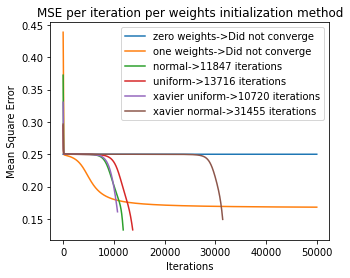

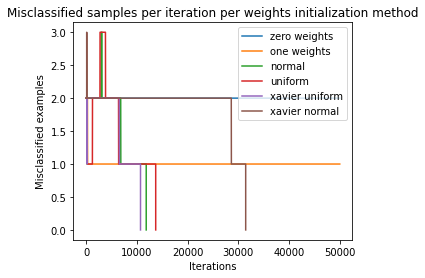

In [ ]:

MAX_ITERATIONS = 50000
LEARNING_RATE = 0.1
ACTIVATION_FUNCTION = Sigmoid()

generator = np.random.RandomState(42)

WEIGHTS_INITIALIZATION_EXPERIMENTS = [
  Experiment(
    name='zero weights',
    initial_weights=zero_weights(),
    activation_function=ACTIVATION_FUNCTION,
    learning_rate=LEARNING_RATE,
    max_iterations=MAX_ITERATIONS,
  ),
  Experiment(
    name='one weights',
    initial_weights=one_weights(),
    activation_function=ACTIVATION_FUNCTION,
    learning_rate=LEARNING_RATE,
    max_iterations=MAX_ITERATIONS,
  ),
  Experiment(
    name='normal',
    initial_weights=weights_from_normal_distribution(generator),
    activation_function=ACTIVATION_FUNCTION,
    learning_rate=LEARNING_RATE,
    max_iterations=MAX_ITERATIONS,
  ),
  Experiment(
    name='uniform',
    initial_weights=weights_from_uniform_distribution(generator),
    activation_function=ACTIVATION_FUNCTION,
    learning_rate=LEARNING_RATE,
    max_iterations=MAX_ITERATIONS,
  ),  
  Experiment(
    name='xavier uniform',
    initial_weights=xavier_uniform_initialization(generator),
    activation_function=ACTIVATION_FUNCTION,
    learning_rate=LEARNING_RATE,
    max_iterations=MAX_ITERATIONS,
  ),
  Experiment(
    name='xavier normal',
    initial_weights=xavier_normal_initialization(generator),
    activation_function=ACTIVATION_FUNCTION,
    learning_rate=LEARNING_RATE,
    max_iterations=MAX_ITERATIONS,
  )
]

cmap = plt.get_cmap("tab10")
figure1, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.set_title('MSE per iteration per weights initialization method')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Mean Square Error')

figure2, ax2 = plt.subplots(1, 1, figsize=(5, 4))
ax2.set_title('Misclassified samples per iteration per weights initialization method')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Misclassified examples')

for i, experiment in enumerate(WEIGHTS_INITIALIZATION_EXPERIMENTS):
  results = execute(experiment)
  plot_mse_per_iteration_with_color(results, ax1, cmap(i))
  plot_misclassified_samples_per_iteration_with_color(results, ax2, cmap(i))

ax1.legend()
ax2.legend()


### Experiments on learning rates


Experiment name: "lr:0.001"
Gradients of last iteration:
{'input_to_hidden_bias_gradients': array([[0.00117834],
       [0.00161934]]), 'input_to_hidden_weights_gradients': array([[ 0.00068452, -0.00109115],
       [ 0.00202186, -0.00330184]]), 'hidden_to_output_bias_gradient': array([[-1.68985088e-05]]), 'hidden_to_output_weight_gradients': array([[ 9.77073116e-05, -6.26787926e-04]])}
Experiment name: "lr:0.01"
Gradients of last iteration:
{'input_to_hidden_bias_gradients': array([[-0.00871375],
       [ 0.00138973]]), 'input_to_hidden_weights_gradients': array([[ 0.01053241, -0.01201979],
       [ 0.00371359, -0.00556471]]), 'hidden_to_output_bias_gradient': array([[-0.01082363]]), 'hidden_to_output_weight_gradients': array([[ 0.01564998, -0.00658696]])}
Experiment name: "lr:0.1"
Gradients of last iteration:
{'input_to_hidden_bias_gradients': array([[-0.00871256],
       [ 0.00138779]]), 'input_to_hidden_weights_gradients': array([[ 0.01053922, -0.01201786],
       [ 0.0037106 , -0.0

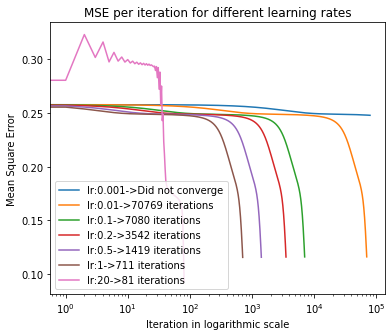

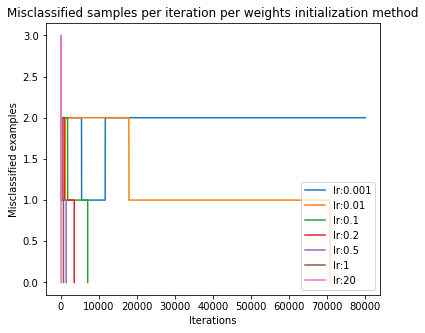

In [ ]:

MAX_ITERATIONS = 80000
ACTIVATION_FUNCTION = Sigmoid()
INITIAL_WEIGHTS = xavier_uniform_initialization(np.random.RandomState(41))
LEARNING_RATES = [
  0.001,
  0.01,
  0.1,
  0.2,
  0.5,
  1,
  20,
]

LEARNING_RATE_EXPERIMENTS = [
  Experiment(
    name=f'lr:{learning_rate}',
    initial_weights=INITIAL_WEIGHTS,
    activation_function=ACTIVATION_FUNCTION,
    learning_rate=learning_rate,
    max_iterations=MAX_ITERATIONS,
  )
  for learning_rate in LEARNING_RATES
]

cmap = plt.get_cmap("tab10")
figure1, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title('MSE per iteration for different learning rates')
ax1.set_xlabel('Iteration in logarithmic scale')
ax1.set_xscale('log')
ax1.set_ylabel('Mean Square Error')

figure2, ax2 = plt.subplots(1, 1, figsize=(6, 5))
ax2.set_title('Misclassified samples per iteration per weights initialization method')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Misclassified examples')

for index, experiment in enumerate(LEARNING_RATE_EXPERIMENTS):
  results = execute(experiment)
  plot_mse_per_iteration_with_color(results, ax1, cmap(index))
  plot_misclassified_samples_per_iteration_with_color(results, ax2, cmap(index))

ax1.legend()
ax2.legend()



### Experiments on random weights



In [ ]:
number_of_successful_xor_nets = 0
max_iterations = 100000
ranges_of_random_weights = [
  (0, 1),
  (-1, 1),
  (-10, 10),
  (-100, 100)
]

for range_of_random_weights in ranges_of_random_weights:
  low = range_of_random_weights[0]
  high = range_of_random_weights[1]
  for i in range(max_iterations):
    random_wights_xor_net = XorNet(
      initial_weights=random_weights(low, high),
      activation_function=Sigmoid(),
      learning_rate=None
    )
    if random_wights_xor_net.misclassified_samples() == 0:
      number_of_successful_xor_nets += 1

  print(
    f'XOR nets with random weights from {low} to {high} computed successfully the XOR function {number_of_successful_xor_nets} times out of {max_iterations} tries')


XOR nets with random weights from 0 to 1 computed successfully the XOR function 0 times out of 100000 tries
XOR nets with random weights from -1 to 1 computed successfully the XOR function 0 times out of 100000 tries
XOR nets with random weights from -10 to 10 computed successfully the XOR function 52 times out of 100000 tries
XOR nets with random weights from -100 to 100 computed successfully the XOR function 131 times out of 100000 tries



### Experiments on different activation functions


In [ ]:

MAX_ITERATIONS = 100000

normally_initialized_weights = weights_from_normal_distribution(np.random.RandomState(11))
xavier_initialized_weights = xavier_uniform_initialization(np.random.RandomState(11))
he_initialized_weights = he_initialization(np.random.RandomState(40))

ACTIVATION_FUNCTION_EXPERIMENTS = [
  Experiment(
    name='Tanh, normal, 0.1 lr',
    initial_weights=normally_initialized_weights,
    activation_function=Tanh(),
    learning_rate=0.1,
    max_iterations=MAX_ITERATIONS,
  ),
  Experiment(
    name='Tanh, xavier, 0.1 lr',
    initial_weights=xavier_initialized_weights,
    activation_function=Tanh(),
    learning_rate=0.1,
    max_iterations=MAX_ITERATIONS,
  ),
  # Experiment(
  #   name='ReLu, he, 0.1 lr',
  #   initial_weights=he_initialized_weights,
  #   activation_function=Relu(),
  #   learning_rate=0.1,
  #   max_iterations=MAX_ITERATIONS,
  # ),
  Experiment(
    name='ReLu, he, 0.01 lr',
    initial_weights=he_initialized_weights,
    activation_function=Relu(),
    learning_rate=0.01,
    max_iterations=MAX_ITERATIONS,
  ),
  Experiment(
    name='LeakyReLu, he, 0.1 lr',
    initial_weights=he_initialized_weights,
    activation_function=LeakyRelu(),
    learning_rate=0.1,
    max_iterations=MAX_ITERATIONS,
  ),
  Experiment(
    name='LeakyReLu, he, 0.01 lr',
    initial_weights=he_initialized_weights,
    activation_function=LeakyRelu(),
    learning_rate=0.01,
    max_iterations=MAX_ITERATIONS,
  ),
  Experiment(
    name='Elu, he, 0.01 lr',
    initial_weights=he_initialized_weights,
    activation_function=Elu(),
    learning_rate=0.01,
    max_iterations=MAX_ITERATIONS,
  ),
]

cmap = plt.get_cmap("tab10")

figure, ax1 = plt.subplots(1, 1, figsize=(6, 5))
ax1.set_title('MSE per iteration for different activation functions')
ax1.set_xlabel('Iterations in logarithmic scale')
ax1.set_xscale('log')
ax1.set_ylabel('Mean Square Error')


figure2, ax2 = plt.subplots(1, 1, figsize=(6, 5))
ax2.set_title('Misclassified samples per iteration per weights initialization method')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Misclassified examples')

for index, experiment in enumerate(ACTIVATION_FUNCTION_EXPERIMENTS):
  results = execute(experiment)
  plot_mse_per_iteration_with_color(results, ax1, cmap(index))
  plot_misclassified_samples_per_iteration_with_color(results, ax2, cmap(index))

ax1.legend()
ax2.legend()